In [21]:
import numpy as np
from queue import SimpleQueue
import PIL
%matplotlib inline
from matplotlib import image
from PIL import Image, ImageOps, ImageFont, ImageDraw
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [2]:
class Node:
    def __init__(self,alphabet_len, word, num = None, parent = None):
        self.parent = parent
        self.children = [None for i in range(alphabet_len)]
        self.word = word
        self.num = num

In [3]:
def trie(pattern):
    n,k = pattern.shape
    alphabet = list(set(pattern.reshape(1,-1)[0]))
    cols = {tuple(pattern[:,i]) for i in range(len(pattern[0]))}
    substring_list = [{col[:i] for i in range(len(col)+1)} for col in cols]
    substrings =set()
    for substring in substring_list:
        substrings.update(substring)
    to_find = dict()
    for i in range(k):
        word = tuple(pattern[:,i])
        if word in to_find:
            to_find[word].add(i)
        else:
            to_find[word]=set([i])
    index = 1
    al = len(alphabet)
    tree = Node(al, tuple(), 0)
    words = SimpleQueue()
    words.put(tree)
    find_seq = {}
    while not words.empty():
        node = words.get()
        if node.word in to_find:
            find_seq[node.num] = to_find[node.word]
        if len(node.word) == n+1:
            continue
        for i,letter in enumerate(alphabet):
            new_word = node.word+(letter,)
            if new_word in substrings:
                child = Node(al,new_word,index,node)
                node.children[i] = child
                index +=1
                words.put(child)
    inverse_find_seq = [None for i in range(k)]
    for key, val in find_seq.items():
        for i in val:
            inverse_find_seq[i] = key    
    return tree, alphabet, inverse_find_seq
                

In [4]:
def tree_dict(tree):
    Q = SimpleQueue()
    Q.put(tree)
    t_dict = {}
    while not Q.empty():
        x = Q.get()
        if x is not None:
            t_dict[x.num] = x
            for child in x.children:
                Q.put(child)
    return t_dict

In [5]:
def automaton(pattern):
    tree, alphabet, inverse_find_seq = trie(pattern)
    node_index = tree_dict(tree)
    n = len(node_index)
    a_index = {alphabet[i]:i for i in range(len(alphabet))}
    transition = np.array([[None for i in alphabet] for j in range(n)])
    for i in range(len(alphabet)):
        transition[0,i] = 0
    BFS_queue = SimpleQueue()
    for child in tree.children:
        if child:
            BFS_queue.put(child)
    while not BFS_queue.empty():
        x = BFS_queue.get()
        a = x.word[-1]
        t = x.parent
        for child in x.children:
            if child:
                BFS_queue.put(child)
        prev_state = transition[t.num,a_index[a]]
        prev_node = node_index[prev_state]
        transition[t.num,a_index[a]] = x.num
        for i,letter in enumerate(alphabet):
            if prev_node.children[i] is not None:
                transition[x.num,i] = prev_node.children[i].num
            else:
                transition[x.num,i] = transition[prev_node.num,i]
    return transition, np.array(inverse_find_seq), a_index

In [6]:
def search_for_pattern(text, pattern):
    transition, find_seq, alphabet = automaton(pattern)
    #print(transition)
    #print(find_seq)
    #print(alphabet)
    n = find_seq.shape
    l_transition, find_sign, numbers = automaton(find_seq.reshape(n[0],1))
    numbers = {int(key):val for key,val in numbers.items()}
    #print(l_transition)
    #print(find_sign)
    n, k =text.shape
    states = np.zeros((n+1, k+1),dtype = np.int32)
    line_states = np.zeros((n+1, k+1),dtype = np.int32)
    found =[]
    for i in range(1,n+1):
        line_state = 0
        for j in range(1,k+1):
            if text[i-1,j-1] in alphabet:
                states[i,j] = transition[int(states[i-1,j]),alphabet[text[i-1,j-1]]]
            else:
                states[i,j] = 0
            state_str = states[i,j]
            if state_str in numbers:
                line_state = l_transition[line_state,numbers[state_str]]
            else:
                line_state = 0
            if line_state == find_sign:
                found.append((i-1,j-1))
    return found

In [7]:
pat = np.array([['a','b','a'],['a','a','a'],['a','a','a']])
text = np.array([['a','b','a','c'],['c','a','b','a'],['d','a','a','a'],['a','a','a','a']])

In [8]:
search_for_pattern(text,pat)

[(3, 3)]

In [9]:
with open("haystack.txt","r") as text_file:
    lines =text_file.readlines()

W poniższych przykładach wystąpienia wzorca są reprezentowane jako tupla (wiersz, numer znaku w wierszu)

In [10]:
n = len(lines)
result = []
for i in range(1,n):
    t1 = np.array(list(lines[i]))
    t2 = np.array(list(lines[i-1]))
    k = min(len(t1),len(t2))
    text = np.vstack((t1[:k],t2[:k]))
    for j in range(255):
        pattern = np.array([[chr(j)],[chr(j)]])
        found = search_for_pattern(text,pattern)        
        for f in found:
            result.append((i,f[1]))
result

[(1, 10),
 (1, 27),
 (1, 58),
 (1, 73),
 (1, 82),
 (1, 63),
 (1, 83),
 (1, 7),
 (2, 2),
 (2, 10),
 (2, 34),
 (2, 8),
 (2, 5),
 (2, 9),
 (2, 4),
 (2, 6),
 (2, 7),
 (2, 3),
 (3, 2),
 (4, 41),
 (4, 44),
 (4, 30),
 (4, 54),
 (4, 57),
 (4, 63),
 (4, 37),
 (5, 7),
 (5, 64),
 (5, 77),
 (5, 75),
 (5, 49),
 (5, 14),
 (5, 23),
 (6, 7),
 (6, 9),
 (6, 45),
 (6, 60),
 (6, 66),
 (7, 45),
 (7, 63),
 (7, 38),
 (7, 39),
 (7, 50),
 (8, 65),
 (8, 38),
 (8, 13),
 (8, 29),
 (9, 25),
 (9, 37),
 (9, 21),
 (9, 75),
 (10, 48),
 (10, 60),
 (10, 58),
 (11, 7),
 (11, 11),
 (11, 45),
 (11, 1),
 (11, 64),
 (11, 27),
 (14, 60),
 (14, 10),
 (14, 55),
 (15, 58),
 (15, 2),
 (15, 54),
 (16, 11),
 (16, 58),
 (16, 43),
 (16, 60),
 (16, 18),
 (16, 12),
 (17, 5),
 (17, 3),
 (18, 6),
 (18, 14),
 (19, 32),
 (19, 27),
 (20, 3),
 (20, 55),
 (20, 37),
 (20, 54),
 (20, 33),
 (21, 3),
 (21, 11),
 (21, 39),
 (21, 51),
 (21, 76),
 (21, 6),
 (21, 10),
 (21, 56),
 (21, 54),
 (22, 49),
 (22, 51),
 (22, 59),
 (22, 69),
 (22, 61),
 (22, 

In [11]:
n = len(lines)
result = []
pattern = np.array([['t','h'],['t','h']])
for i in range(1,n):
    t1 = np.array(list(lines[i]))
    t2 = np.array(list(lines[i-1]))
    k = min(len(t1),len(t2))
    text = np.vstack((t1[:k],t2[:k]))
    found = search_for_pattern(text,pattern)        
    for f in found:
        result.append((i,f[1]))
result

[]

In [12]:
n = len(lines)
result = []
pattern = np.array([['t',' ','h'],['t',' ','h']])
for i in range(1,n):
    t1 = np.array(list(lines[i]))
    t2 = np.array(list(lines[i-1]))
    k = min(len(t1),len(t2))
    text = np.vstack((t1[:k],t2[:k]))
    found = search_for_pattern(text,pattern)        
    for f in found:
        result.append((i,f[1]))
result

[(38, 2)]

In [13]:
def prepare_img(img_path):
    img = Image.open(img_path)
    gray_scale = img.convert('L')
    return np.array(gray_scale)

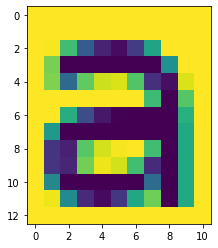

[(47, 216), (47, 272), (47, 332), (47, 496), (47, 632), (47, 760), (69, 312), (69, 342), (69, 400), (69, 651), (69, 709), (91, 186), (91, 212), (91, 408), (91, 574), (91, 598), (113, 65), (113, 114), (113, 281), (135, 283), (135, 337), (135, 628), (157, 135), (157, 165), (157, 256), (157, 363), (157, 558), (157, 641), (179, 65), (179, 99), (179, 203), (179, 331), (179, 527), (179, 566), (179, 595), (179, 717), (201, 93), (201, 267), (201, 415), (201, 586), (201, 630), (201, 689), (223, 444), (223, 545), (245, 129), (245, 481), (245, 602), (267, 103), (267, 455), (289, 72), (289, 135), (289, 278), (289, 469), (289, 572), (311, 46), (333, 97), (333, 185), (333, 444), (333, 504), (333, 582), (355, 107), (355, 231), (355, 282), (355, 418), (355, 586), (377, 35), (377, 257), (377, 283), (377, 613), (377, 666), (399, 129), (399, 237), (399, 379), (399, 714), (421, 35), (443, 257), (443, 292), (443, 521), (443, 603), (443, 664), (465, 93), (465, 137), (465, 254), (465, 376), (465, 458), (487,

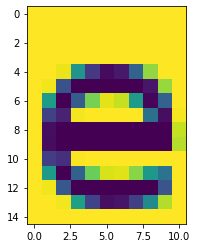

[(47, 60), (47, 118), (47, 183), (47, 389), (47, 603), (47, 749), (69, 99), (69, 134), (69, 255), (69, 446), (69, 478), (69, 564), (91, 46), (91, 104), (91, 282), (91, 315), (91, 347), (91, 454), (91, 563), (91, 624), (91, 657), (91, 689), (113, 86), (113, 138), (113, 213), (113, 237), (113, 326), (113, 503), (113, 609), (135, 91), (135, 162), (135, 248), (135, 418), (135, 553), (135, 705), (157, 62), (157, 234), (157, 285), (157, 341), (157, 408), (179, 249), (179, 668), (179, 700), (201, 183), (201, 313), (201, 348), (201, 652), (201, 711), (223, 89), (223, 184), (223, 253), (223, 409), (223, 577), (223, 634), (245, 92), (245, 162), (245, 195), (245, 227), (245, 293), (245, 365), (245, 446), (245, 666), (245, 736), (267, 45), (267, 236), (267, 309), (267, 393), (267, 545), (267, 593), (267, 625), (289, 46), (289, 221), (289, 452), (289, 526), (289, 618), (289, 688), (311, 35), (311, 113), (333, 69), (333, 145), (333, 252), (333, 465), (333, 529), (355, 55), (355, 138), (355, 527), (3

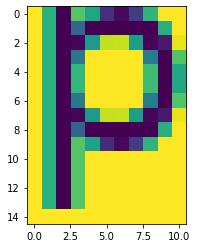

[(51, 167), (51, 378), (51, 565), (73, 244), (117, 464), (139, 35), (139, 310), (139, 666), (161, 392), (161, 518), (205, 144), (205, 454), (227, 145), (249, 349), (271, 264), (271, 516), (293, 391), (337, 207), (337, 493), (359, 676), (381, 177), (381, 456), (381, 624), (381, 635), (403, 368), (425, 144), (447, 154), (491, 120), (491, 193), (491, 390), (513, 437), (535, 223), (557, 251), (557, 647), (601, 151), (601, 351), (645, 257), (667, 134), (667, 216), (667, 693), (689, 271), (689, 338), (689, 680), (733, 353), (733, 455), (777, 44), (777, 148), (799, 123), (799, 337), (821, 53), (821, 315), (821, 552), (821, 695), (843, 343), (843, 354), (865, 629), (887, 311), (909, 35), (931, 85), (931, 439), (953, 146), (953, 208), (953, 418), (975, 189), (975, 200), (975, 416), (975, 643), (997, 80), (997, 187), (997, 501), (997, 631), (997, 642), (1041, 596), (1063, 35), (1085, 213), (1085, 464), (1107, 42), (1107, 367), (1129, 664), (1173, 135), (1195, 286), (1217, 418), (1217, 429), (123

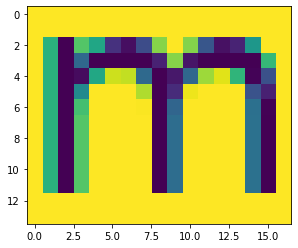

[(48, 155), (48, 737), (114, 626), (136, 271), (136, 570), (158, 380), (158, 689), (180, 122), (180, 405), (180, 515), (202, 518), (202, 536), (224, 518), (246, 64), (246, 337), (246, 555), (268, 148), (268, 326), (268, 504), (290, 266), (334, 269), (334, 570), (356, 486), (356, 515), (356, 568), (356, 664), (378, 239), (378, 584), (400, 88), (400, 225), (400, 356), (422, 82), (444, 216), (466, 399), (488, 108), (488, 306), (488, 452), (488, 562), (510, 110), (510, 686), (532, 385), (554, 176), (554, 561), (554, 635), (576, 444), (598, 747), (664, 294), (664, 384), (664, 470), (664, 681), (686, 668), (708, 119), (752, 278), (796, 401), (796, 419), (796, 611), (818, 377), (818, 569), (818, 683), (840, 404), (862, 713), (884, 638), (906, 97), (906, 167), (928, 73), (950, 62), (950, 80), (1016, 41), (1016, 658), (1038, 41), (1038, 70), (1104, 97), (1104, 429), (1148, 71), (1192, 274), (1192, 319), (1236, 61), (1258, 88), (1280, 75), (1302, 174), (1302, 352), (1324, 117), (1346, 167), (134

In [14]:
n = len(lines)
patterns = ['a','e','p','m']
text = prepare_img("haystack.png")
for p in patterns:
    pattern = prepare_img(p+".png")
    plt.imshow(pattern)
    plt.show()
    found = search_for_pattern(text,pattern)        
    print(found)

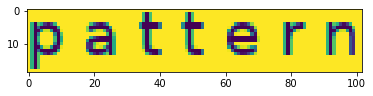

[(491, 284), (513, 528), (557, 342), (601, 242), (645, 348)]


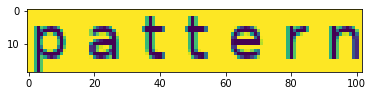

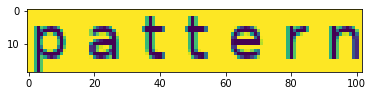

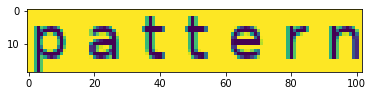

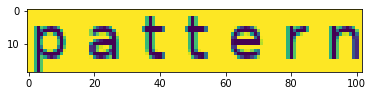

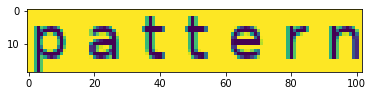

In [16]:
n = len(lines)
text = prepare_img("haystack.png")
pattern = prepare_img("pattern.png")
h,w = pattern.shape
plt.imshow(pattern)
plt.show()
found = search_for_pattern(text,pattern)
print(found)
for x, y in found:
    plt.imshow(text[x -h:x,y-w:y])
    plt.show()

In [19]:
def pattern_search(text, transition, find_seq, alphabet):
    n = find_seq.shape
    l_transition, find_sign, numbers = automaton(find_seq.reshape(n[0],1))
    numbers = {int(key):val for key,val in numbers.items()}
    n, k =text.shape
    states = np.zeros((n+1, k+1),dtype = np.int32)
    line_states = np.zeros((n+1, k+1),dtype = np.int32)
    found =[]
    for i in range(1,n+1):
        line_state = 0
        for j in range(1,k+1):
            if text[i-1,j-1] in alphabet:
                states[i,j] = transition[int(states[i-1,j]),alphabet[text[i-1,j-1]]]
            else:
                states[i,j] = 0
            state_str = states[i,j]
            if state_str in numbers:
                line_state = l_transition[line_state,numbers[state_str]]
            else:
                line_state = 0
            if line_state == find_sign:
                found.append((i-1,j-1))
    return found

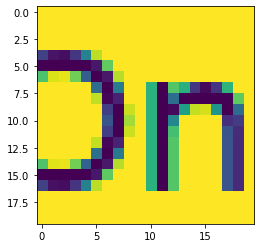

automaton construction time:	0.01991s
pattern searching time:	3.51161s
pattern size:	400 pixels




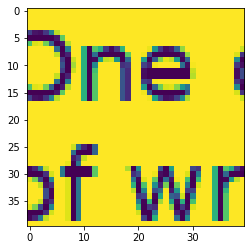

automaton construction time:	0.197544s
pattern searching time:	3.541531s
pattern size:	1600 pixels




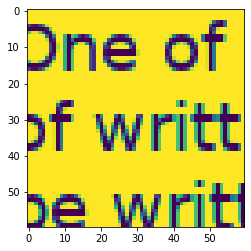

automaton construction time:	0.585437s
pattern searching time:	3.399221s
pattern size:	3600 pixels




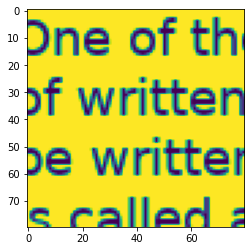

automaton construction time:	1.32446s
pattern searching time:	3.395922s
pattern size:	6400 pixels




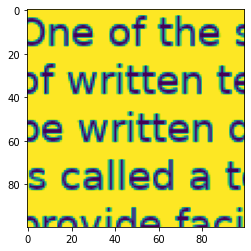

automaton construction time:	2.589687s
pattern searching time:	3.440801s
pattern size:	10000 pixels




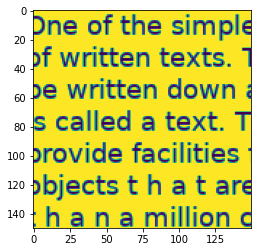

automaton construction time:	6.936456s
pattern searching time:	3.474708s
pattern size:	22500 pixels




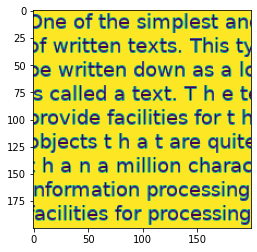

automaton construction time:	14.797359s
pattern searching time:	3.51657s
pattern size:	40000 pixels




In [47]:
lengths = [ 20, 40, 60, 80, 100, 150, 200]
text = prepare_img("haystack.png")
sizes = []
s_times =[]
a_times =[]
for l in lengths:
    pattern = text[30:l+30,30:l+30]
    h,w = pattern.shape
    size = h*w
    automaton_start = dt.now()
    transition, find_seq, alphabet = automaton(pattern)
    automaton_end = dt.now()
    f = pattern_search(text, transition, find_seq, alphabet)
    search_end = dt.now()
    sizes.append(size)
    a_time = (automaton_end-automaton_start).total_seconds()
    a_times.append(a_time)
    s_time =(search_end-automaton_end).total_seconds()
    s_times.append(s_time)
    plt.imshow(pattern)
    plt.show()
    print("automaton construction time:\t"+str(a_time)+"s")
    print("pattern searching time:\t"+str(s_time)+"s")
    print("pattern size:\t"+str(size)+" pixels")
    print("\n")
    #a = automaton(pattern)

Text(0.5, 1.0, 'automaton construction time')

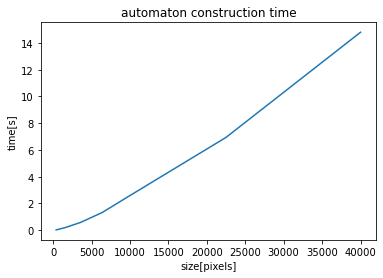

In [49]:
plt.plot(sizes, a_times)
plt.ylabel("time[s]")
plt.xlabel("size[pixels]")
plt.title("automaton construction time")

Text(0.5, 1.0, 'pattern searching time')

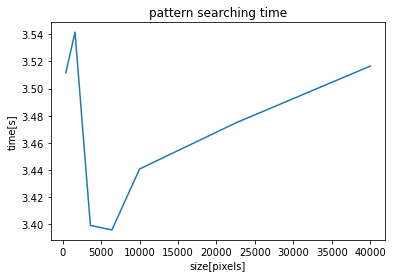

In [50]:
plt.plot(sizes, s_times)
plt.ylabel("time[s]")
plt.xlabel("size[pixels]")
plt.title("pattern searching time")

Możemy zauważyć, że czas konstrukcji automatu jest mniej więcej liniowo zależny od rozmiaru wzorca w pixelach, co potwierdza, że zaimplementowany przeze mnie algorytm ma złożoność obliczeniową O(n). Czas wyszukiwania wzorca wacha się natomiast nieznacznie i można stwierdzić, że jest on niezależny od długości wzorca

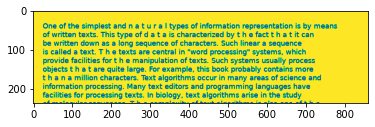

automaton construction time:	0.117684s
pattern searching time:	0.447841s
text size:	203820 pixels




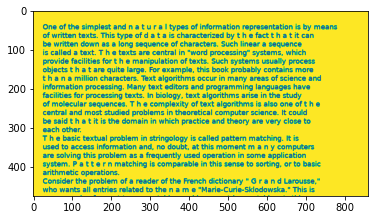

automaton construction time:	0.103472s
pattern searching time:	0.91651s
text size:	408500 pixels




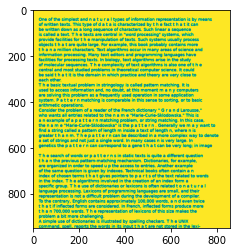

automaton construction time:	0.102686s
pattern searching time:	1.822168s
text size:	817000 pixels




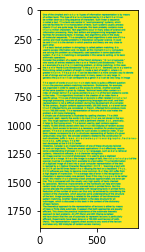

automaton construction time:	0.102074s
pattern searching time:	3.671145s
text size:	1634000 pixels




In [51]:
parts = [ 8, 4, 2, 1]
t = prepare_img("haystack.png")
pattern = prepare_img("pattern.png")
sizes = []
s_times =[]
a_times =[]
h,w = t.shape
for p in parts:
    nh = h//p
    text= t[:nh,:]
    size = nh*w
    automaton_start = dt.now()
    transition, find_seq, alphabet = automaton(pattern)
    automaton_end = dt.now()
    f = pattern_search(text, transition, find_seq, alphabet)
    search_end = dt.now()
    sizes.append(size)
    a_time = (automaton_end-automaton_start).total_seconds()
    a_times.append(a_time)
    s_time =(search_end-automaton_end).total_seconds()
    s_times.append(s_time)
    plt.imshow(text)
    plt.show()
    print("automaton construction time:\t"+str(a_time)+"s")
    print("pattern searching time:\t"+str(s_time)+"s")
    print("text size:\t"+str(size)+" pixels")
    print("\n")
    #a = automaton(pattern)

Text(0.5, 1.0, 'automaton construction time')

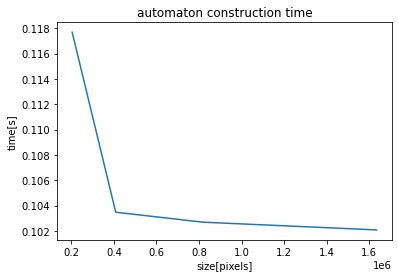

In [52]:
plt.plot(sizes, a_times)
plt.ylabel("time[s]")
plt.xlabel("size[pixels]")
plt.title("automaton construction time")

Text(0.5, 1.0, 'pattern searching time')

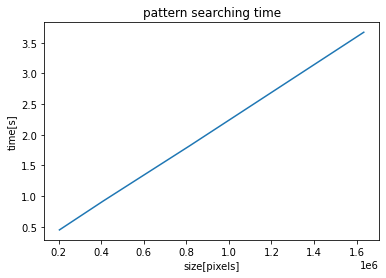

In [53]:
plt.plot(sizes, s_times)
plt.ylabel("time[s]")
plt.xlabel("size[pixels]")
plt.title("pattern searching time")

Możemy zauważyć, że różnice w czasie konstrukcji automatu są bardzo niewielkie.
Świadczy to o braku wpływu wielkości tekstu na czas budowy automatu i zależności tego czasu jedynie od długości wzorca. Dodatkowo zauważyć można, że czas wyszukiwania wzorca jest niemal idealnie liniowo zależny od długości tekstu